In [6]:
import bom_water
from sidecar import Sidecar
from ipyleaflet import Map, GeoJSON, Polygon
from IPython.display import display, clear_output, HTML, JSON
import json
import requests
import geopandas as gpd

## Get Capability

In [ ]:
bm = bom_water.BomWater()
response = bm.request(bm.actions.GetCapabilities)
# response
JSON(bm.xml_to_json( response.text))

## Get Observation

Return data type is a Pandas DataFrame

<AxesSubplot: xlabel='Timestamp[UTC]'>

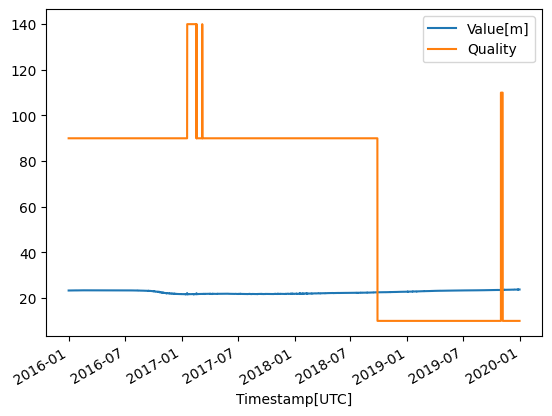

In [3]:
t_begin = "2016-01-01T00:00:00+10"
t_end = "2019-12-31T00:00:00+10"

try:
    response = bm.request(bm.actions.GetObservation, bm.features.Cowra_Back_Ck_Nth_P2, bm.properties.Ground_Water_Level, bm.procedures.Pat9_C_B_1, t_begin, t_end)
except response.exceptions.RequestException as e:
    display(f'BoM service failed with RequestException: {e}')

ts = bm.parse_get_data(response)
ts.plot.line()

## Get Data availability

In [ ]:
response = bm.request(bm.actions.GetDataAvailability, bm.features.Cowra_Back_Ck_Nth_P2, bm.properties.Ground_Water_Level)
JSON(bm.xml_to_json( response.text))

## Get Feature of interest
Simple demo of requesting features within a bounding box and mapping their locations

In [8]:
low_left_lat = -37.505032
low_left_long = 138.00
upper_right_lat = -24.00
upper_right_long = 154.00

lower_left_coords = f'{low_left_lat} {low_left_long}'
upper_right_coords = f'{upper_right_lat} {upper_right_long}'

bm = bom_water.BomWater()

# request( action, feature=None, prop=None, proced=None, begin=None, end=None, lower_corner=None, upper_corner=None)

response = bm.request(bm.actions.GetFeatureOfInterest, None, bm.properties.Water_Course_Discharge, bm.procedures.Pat4_C_B_1_DailyMean, None, None, lower_left_coords, upper_right_coords  )
response_json = bm.xml_to_json(response.text)
'''bomwater creates a FeatureCollection which can be used for mapping'''
feature_list = bm.create_feature_list(response_json, None )

bbox_poly = Polygon(
        locations=[(low_left_lat, low_left_long),(low_left_lat, upper_right_long),(upper_right_lat, upper_right_long),(upper_right_lat, low_left_long)],
    color="green",
    fill_color="green"
        )
m = Map(center=(-32, 146), zoom=5)

geojsonMarkerOptions = {
    'radius': 8,
    'fillColor': "#ff7800",
    'color': "#000",
    'weight': 1,
    'opacity': 1,
    'fillOpacity': 0.8
};

geo_json_stations = GeoJSON(
    data=feature_list,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.8, 'fillColor': 'green', 'weight': 2})

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': 'green',#random.choice(['red', 'yellow', 'green', 'orange']),
    }

shp_mdb = './bomwater_data/Spatial/mdb_buffer_1km.shp'
mdb = json.loads(gpd.read_file(shp_mdb).to_json())['features'][0]['geometry']

geo_json_mdb = GeoJSON(
    data=mdb,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'green', 'dashArray': '0', 'fillOpacity': 0.3
    },
    style_callback=random_color
)

m.add_layer(geo_json_mdb)
# m.add_layer(bbox_poly)
m.add_layer(geo_json_stations)

display(m)

'''Display the json response'''
# JSON(response_json)

Map(center=[-32, 146], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

'Display the json response'